In [1]:
#导入包（PypI）
import requests
from lxml import html
import random
import time
import pandas as pd
import numpy as np
import itertools

In [2]:
url="https://steamstats.cn/peak"
headers={
    'User-Agent':'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/112.0.0.0 Safari/537.36 Edg/112.0.1722.64'
}

In [3]:
name_list=[]
id_list=[]
peak_list=[]

In [4]:
wait_time=random.uniform(1,3)#生成随机等待时间
for i in range(1,11):
    url=f"https://steamstats.cn/peak/{i}"
    data=requests.get(url=url,headers=headers)
    bytes_data=data.content.decode()
    element=html.fromstring(bytes_data)
    links=element.xpath('//tr[@class="pointer"]/td[3]/div/a/@href')#游戏链接
    id=[link.split("/app/")[1] for link in links]#ID
    name=element.xpath('//tr[@class="pointer"]/td[3]/div/a/text()')#游戏名
    name=[n.strip() for n in name]
    peak=element.xpath('//tr[@class="pointer"]/td[4]/text()')#在线峰值
    peak=[p.strip() for p in peak]
    name_list.append(name)
    id_list.append(id)
    peak_list.append(peak)
    time.sleep(wait_time)

In [5]:
id_list=list(itertools.chain.from_iterable(id_list))
name_list=list(itertools.chain.from_iterable(name_list))
peak_list=list(itertools.chain.from_iterable(peak_list))
for i in range(len(peak_list)):
    peak_list[i] = peak_list[i].replace(",", "")

In [6]:
print(id_list)
print(name_list)
print(peak_list)

['578080', '730', '570', '1599340', '1091500', '1245620', '1063730', '990080', '1568590', '1172470', '892970', '1938090', '105600', '1515950', '377160', '532210', '1755910', '945360', '552990', '232770', '271590', '863550', '370910', '582010', '1085660', '343710', '534380', '1449850', '346110', '261550', '218620', '252490', '1326470', '1446780', '448940', '304390', '285800', '1240440', '308600', '275850', '238960', '1046930', '359550', '779340', '1100600', '278360', '1468810', '1203220', '402390', '230410', '1097150', '2075730', '1142710', '96000', '395170', '289070', '231430', '550', '1638720', '1604030', '491950', '433850', '440', '1584640', '252950', '431960', '696370', '638070', '391720', '1724660', '203770', '334210', '268500', '374320', '365450', '424370', '680420', '814380', '49520', '976730', '222880', '477160', '490220', '214950', '232050', '365590', '236390', '304930', '739630', '364360', '2050650', '1811260', '322330', '1361210', '1418630', '1196590', '381210', '782330', '81

In [7]:
dic={
    "ID":id_list,
    "name(Chinese)":name_list,
    "top_players":peak_list
    }

In [8]:
df=pd.DataFrame(pd.DataFrame.from_dict(dic, orient='index').values.T, columns=list(dic.keys()))#整合为DataFrame结构
from pymongo import MongoClient
client=MongoClient(host='localhost',port=27017)#连接MongoDB  
db=client['mongodb_database']
crowd=db['table']  
import json

class MongoBase:
    def __init__(self,collection):
        self.collection=collection
        self.OpenDB()
    def OpenDB(self):
        self.con=MongoClient('localhost',27017)
        self.db=self.con['Steam平台用户活跃数据']#进行操作的库名
        self.collection=self.db[self.collection]
    def closeDB(self):
        self.con.close()

Df_Mongo=MongoBase('MostPlayedGamesTop500')
data = json.loads(df.to_json(orient='records'))
Df_Mongo.collection.insert_many(data)
client.close()
Df_Mongo.closeDB()

In [9]:
data=df.head(30)
data

,ID,name(Chinese),top_players
0,578080,绝地求生,3236027
1,730,反恐精英：全球攻势,1533939
2,570,刀塔2,1291328
3,1599340,Lost Ark,1174722
4,1091500,赛博朋克 2077,1041355
5,1245620,艾尔登法环,953426
6,1063730,New World,912564
7,990080,霍格沃茨之遗,877109
8,1568590,Goose Goose Duck,701118
9,1172470,Apex Legends™,624473


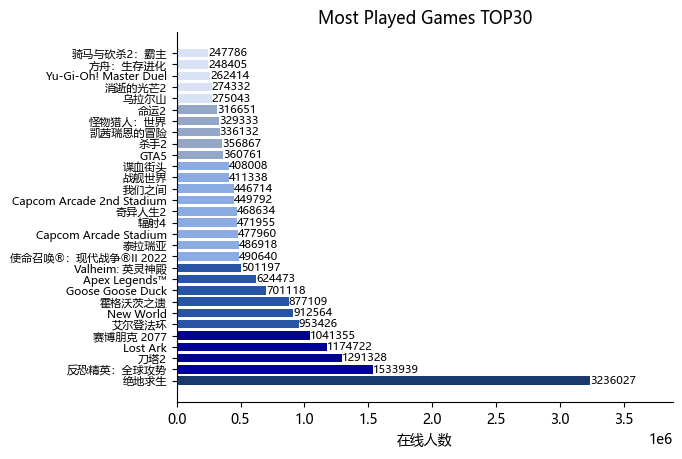

In [10]:
names=data["name(Chinese)"]
values=data["top_players"].astype(int)
#绘制横向条形图
import matplotlib.pyplot as plt
plt.rcParams ['font.sans-serif'] = ['Microsoft YaHei']#正常显示中文和特殊符号
plt.rcParams ['axes.unicode_minus'] = False#正常显示负号
x=range(len(values))
color=[]#存放每个条形的颜色
for i in range(len(values)):
    if values[i] >= 3000000:
        color.append('#1A396D')
    elif values[i] >= 1000000 and values[i]<3000000:
        color.append('#000094')
    elif values[i] >= 500000 and values[i]<1000000:
        color.append('#2755A4')
    elif values[i] >= 400000 and values[i]<500000:
        color.append('#8BACE3')
    elif values[i] >= 300000 and values[i]<400000:
        color.append('#95A7C7')
    else:
        color.append('#D8E3F6')
rects = plt.barh(names, values, height=0.75, color=color)
#为条形右侧添加数据标签
for rect in rects:#遍历所有柱
	x_pos = rect.get_width()#定位文字横坐标
	plt.text(x_pos, rect.get_y()+rect.get_height()/2, '%d' %
            int(x_pos), ha='left', va='center', fontsize=8)

plt.tick_params(axis='y',which='major',labelsize=8)#调整y轴刻度标签字体大小
plt.xlabel("在线人数")#设置x轴标签
plt.title("Most Played Games TOP30")
ax = plt.gca()#获取坐标轴对象
ax.spines['right'].set_color('none')#删除右边框
ax.spines['top'].set_color('none')#删除上边框
plt.xlim(0,max(values)*1.2)#将x轴范围扩展20%，给数据标签留出空间以防与边框重合

plt.savefig('条形图(缩放)-Most Played Games TOP30.png')
plt.show()